## Imports

In [1]:
import numpy as np
import pandas as pd
import random
import shap
from math import sqrt
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

from scipy.stats import sem, t
from scipy import mean

import warnings
warnings.filterwarnings('ignore')

import pickle

In [2]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout

## Genotype & Phenotype Simulation

In [3]:
#Simulate Genotype
def simulate_genotype(samples_n, loci_m):
    f_M = np.random.uniform(0,1,loci_m)
    G = np.random.binomial(n=2,p = f_M, size = (samples_n,loci_m))
    G = preprocessing.scale(G, axis=0)
    
    assert(len(G) == samples_n)
    assert(len(G[0])== loci_m)
    return G

### Set beta and envi noise

In [4]:
def simulate_genotype_and_phenotype_set(samples_n, loci_m,var_g,var_e,b12_event):
    G = simulate_genotype(samples_n, loci_m)
    individuals = len(G)    
    sigma_e = sqrt(var_e)
    sigma_b = sqrt(var_g/2)
    #b_i = loci effect on phenotype
    b_1 = var_g
    b_2 = var_g
    loci =random.sample(range(0, loci_m), 2)
    SNP1 = G[:,loci[0]]
    SNP2 = G[:,loci[1]]
    individuals = len(SNP1)    
    #rows are the loci so each person has a row of different loci
    Y_n = np.zeros((individuals, 1));
    
    #depending on b1_event b12 will be different
    # if 0 then b12 has no effect
    if (b12_event == 0):
        b_12 = 0
    #if 1 then Random Combined Effect
    elif(b12_event == 1):
        b_12 = np.random.normal(0, sigma_b)
    #if 2 then: 0 < b_12 < b1
    elif(b12_event == 2):
        b_12 = random.uniform(0, abs(b_1))
    #if 3 then: 0 < b_12 < b2
    elif(b12_event == 3):
        b_12 = random.uniform(0, abs(b_2))
    #if 4 then: b_1 + b_2 < b_12
    elif(b12_event == 4):
        b_12 = random.uniform(abs(b_1) + abs(b_2), 1)
    #if 5 then: b_12 < 0
    elif(b12_event == 5):
        b_12 = random.uniform(-1 * sigma_b, 0)
             
    #create phenotype vector
    for k in range(0, individuals):
        #each individual will have a random e_j(noise) value
        e_j = np.random.normal(0, var_e)
        #G_ij will be the jth individual from our SNP for the loci of choice
        G_ij1  = SNP1[k]
        G_ij2  = SNP2[k]
        Y_j = (b_1*G_ij1) + (b_2*G_ij2) + (b_12 * (G_ij1 * G_ij2))+ e_j 
        Y_n[k] = Y_j 
    #add Y traits to G matrix
    G = np.append(G, Y_n, axis=1)
    return G, loci

#Provide var_g, var_e and get G with genotype & Phenotype data
def simulate_genotype_and_phenotype_var(samples_n, loci_m,var_g,var_e,b12_event):
    G = simulate_genotype(samples_n, loci_m)
    individuals = len(G)    
    sigma_e = sqrt(var_e)
    sigma_b = sqrt(var_g/2)
    #b_i = loci effect on phenotype
    b_1 = np.random.normal(0, sigma_b)
    b_2 = np.random.normal(0, sigma_b)
    loci =random.sample(range(0, loci_m), 2)
    SNP1 = G[:,loci[0]]
    SNP2 = G[:,loci[1]]
    individuals = len(SNP1)    
    #rows are the loci so each person has a row of different loci
    Y_n = np.zeros((individuals, 1));
    
    #depending on b1_event b12 will be different
    # if 0 then b12 has no effect
    if (b12_event == 0):
        b_12 = 0
    #if 1 then Random Combined Effect
    elif(b12_event == 1):
        b_12 = np.random.normal(0, sigma_b)
    #if 2 then: 0 < b_12 < b1
    elif(b12_event == 2):
        b_12 = random.uniform(0, abs(b_1))
    #if 3 then: 0 < b_12 < b2
    elif(b12_event == 3):
        b_12 = random.uniform(0, abs(b_2))
    #if 4 then: b_1 + b_2 < b_12
    elif(b12_event == 4):
        b_12 = random.uniform(abs(b_1) + abs(b_2), 1)
    #if 5 then: b_12 < 0
    elif(b12_event == 5):
        b_12 = random.uniform(-1 * sigma_b, 0)
             
    #create phenotype vector
    for k in range(0, individuals):
        #each individual will have a random e_j(noise) value
        e_j = np.random.normal(0, sigma_e)
        #G_ij will be the jth individual from our SNP for the loci of choice
        G_ij1  = SNP1[k]
        G_ij2  = SNP2[k]
        Y_j = (b_1*G_ij1) + (b_2*G_ij2) + (b_12 * (G_ij1 * G_ij2))+ e_j 
        Y_n[k] = Y_j 
    #add Y traits to G matrix
    G = np.append(G, Y_n, axis=1)
    return G, loci

## Random Forest Regression & SHAP 

In [5]:
def shap_RFR_tree_train(G):
    X = G[:,0:len(G[0])-1]
    y = G[:,len(G[0])-1]
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
    forReg = RandomForestRegressor(max_depth=10, random_state=0, n_estimators=50)
    forReg.fit(x_train, y_train)
    shap_values = shap.TreeExplainer(forReg).shap_values(x_train)
    return shap_values, x_train

def shap_feature_plot_RFR(shap_values, x_train):
    shap.summary_plot(shap_values, x_train, plot_type="bar")

## NN & SHAP 

In [6]:
def shap_RFR_tree_train(G):
    X = G[:,0:len(G[0])-1]
    y = G[:,len(G[0])-1]
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
    model = Sequential()
    model.add(Dense(32, activation='relu', input_dim = len(X[0])))
    model.add(Dropout(0.25))
    model.add(Dense(1, activation='relu', input_dim = 32))
    model.add(Dropout(0.25))
    model.compile(loss='mean_absolute_error', optimizer='rmsprop')
    model.fit(x_train, y_train, epochs=50, batch_size=256, verbose = 0)
    explainer = shap.DeepExplainer(model, x_train)
    shap_values = explainer.shap_values(x_test)
    return shap_values, x_train

def shap_feature_plot_RFR(shap_values, x_train):
    shap.summary_plot(shap_values, x_train, plot_type="bar")

## Calculate SHAP for NN

In [7]:
# FOR RFR
def mean_shap_values(shap_values):
    shap_values = np.array(shap_values)
    avg_shap = []
    for i in range(0,len(shap_values[0])):
        shap2 = np.mean(abs(shap_values[:,i]))
        avg_shap.append(shap2)
    return avg_shap

## FOR NNN
# def mean_shap_values(shap_values):
#     shap_values = np.array(shap_values)
#     shap_values2 = np.zeros((len(shap_values[0]),len(shap_values[0][0])))
#     shap_values2[:][:] = shap_values[0,:,:]
# #     shap_values2 = np.array(shap_values2)
#     avg_shap = []
#     for i in range(0,len(shap_values2[0])):
#         shap2 = np.mean(abs(shap_values2[:,i]))
#         avg_shap.append(shap2)
#     return avg_shap   

def max_mean_feature(shap_values):
    avg_shap = mean_shap_values(shap_values)
    temp1 = np.asarray(avg_shap)
    indices = temp1.argsort()[-2:][::-1]
    loci1,loci2 = avg_shap[indices[0]],avg_shap[indices[1]]
    return indices

## Calculating Accuracy

In [15]:
def shap_acc_RFR_set(samples_n, loci_m, beta_g, e_noise, number_trials,b12_event, confidence = 0.95):
    shap_values_SNP = []
    counter = 0
    while counter != number_trials:
        G, loci = simulate_genotype_and_phenotype_set(samples_n, loci_m,beta_g,e_noise,b12_event)
        shap_values_holder, x_train = shap_RFR_tree_train(G)
        max_holder = max_mean_feature(shap_values_holder)
        
        if (max_holder[0] == loci[0] and max_holder[1] == loci[1]):
            shap_values_SNP.append(1)
        elif(max_holder[0] == loci[1] and max_holder[1] == loci[0]):
            shap_values_SNP.append(1)
        elif (max_holder[0] == loci[0] and max_holder[1] != loci[1]):
            shap_values_SNP.append(.5)
        elif (max_holder[0] != loci[0] and max_holder[1] == loci[1]):
            shap_values_SNP.append(.5)
        else:
            shap_values_SNP.append(0)
        counter += 1
    
    percent = sum(shap_values_SNP) / len(shap_values_SNP) * 100
    
    n = len(shap_values_SNP)
    m = mean(shap_values_SNP)
    std_err = sem(shap_values_SNP)
    confidence_int = std_err * t.ppf((1 + confidence) / 2, n - 1)
    
    return percent, confidence_int
    

def shap_acc_RFR_var(samples_n, loci_m, var_g, var_e, number_trials,b12_event):
    shap_values_SNP = []
    counter = 0
    while counter != number_trials:
        G, loci = simulate_genotype_and_phenotype_var(samples_n,loci_m, var_g , var_e,b12_event)
        shap_values_holder, x_train = shap_RFR_tree_train(G)
        max_holder = max_mean_feature(shap_values_holder)
        if (max_holder[0] == loci[0] and max_holder[1] == loci[1]):
            shap_values_SNP.append(1)
        elif(max_holder[0] == loci[1] and max_holder[1] == loci[0]):
            shap_values_SNP.append(1)
        elif (max_holder[0] == loci[0] and max_holder[1] != loci[1]):
            shap_values_SNP.append(.5)
        elif (max_holder[0] != loci[0] and max_holder[1] == loci[1]):
            shap_values_SNP.append(.5)
        else:
            shap_values_SNP.append(0)
        counter += 1
    percent = sum(shap_values_SNP) / len(shap_values_SNP) * 100
    confidence_int = 1
    return percent, confidence_int

In [16]:
#samples_n = 100
#loci_m = 10
#number_trials = 100
#beta_g, e_noise = 0.9, 0.2
#percent, confidence_int = shap_acc_RFR_set(samples_n, loci_m, beta_g, e_noise , number_trials, confidence = 0.95)
#print(percent)
#print(confidence_int)
    
#pickle.dump( [percent, beta_g, e_noise, confidence_int], open( "save.p", "wb" ) )

In [17]:
#favorite_color = pickle.load( open( "save.p", "rb" ) )
#print(favorite_color)

## Graphing

In [18]:
#Line Plots
def plot_shap_values_RFR_line_single(samples_n, loci_m, range_values, e_val, number_trials,b12_event, data_type = 'set'):
    
    increment = 1/range_values
    holderg = 0
    g_vals = [0]
    
    for x in range(1, range_values):
        g_vals.append(holderg + increment)
        holderg = holderg + increment
    
    shap_values_SNP = []
    
    if data_type == 'set':
        for x in range(0,range_values):
            percent, confidence_int = shap_acc_RFR_set(samples_n, loci_m, g_vals[x], e_val, number_trials,b12_event)
            shap_values_SNP.append(percent)
    elif data_type == 'var':
        for x in range(0,range_values):
            percent, confidence_int = shap_acc_RFR_var(samples_n, loci_m, g_vals[x], e_val, number_trials,b12_event)
            shap_values_SNP.append(percent)

            
    plt.plot(g_vals, shap_values_SNP) 
    
    if data_type == 'set':
        plt.xlabel('Value of Genetic Effect')
        plt.ylabel('Percent accuracy of feature selection')
        plt.title('Effect of Genetic Effect on SHAP Accuracy in Feature Selection') 
    elif data_type == 'var':
        plt.xlabel('Variance of Genetic Effect')
        plt.ylabel('Percent accuracy of feature selection')
        plt.title('Effect of Variance Genetic Effect on SHAP Accuracy in Feature Selection') 
        
    plt.show()

In [19]:
#Line Plots
def plot_shap_values_RFR_line_multiple(samples_n, loci_m, range_values_g, range_values_e, number_trials,b12_event, name = 'nameme', data_type = 'set'):
    
    increment_g = 1/range_values_g
    increment_e = 1/range_values_e
    holderg = 0
    holdere = 0
    g_vals = [0]
    e_vals = [0]
    
    for x in range(1, range_values_g):
        g_vals.append(holderg + increment_g)
        holderg = holderg + increment_g
        
    for x in range(1, range_values_e):
        e_vals.append(holdere + increment_e)
        holdere = holdere + increment_e
    
    
    shap_values_SNP = []
    
    if data_type == 'set':
        for y in range(0, range_values_e):
            shap_values_SNP_holder = []
            for x in range(0,range_values_g):
                percent, confidence_int = shap_acc_RFR_set(samples_n, loci_m, g_vals[x], e_vals[y], number_trials,b12_event)
                shap_values_SNP_holder.append(percent)
            shap_values_SNP.append(shap_values_SNP_holder)
    elif data_type == 'var':
        for y in range(0, range_values_e):
            shap_values_SNP_holder = []
            for x in range(0,range_values_g):
                percent, confidence_int = shap_acc_RFR_var(samples_n, loci_m, g_vals[x], e_vals[y], number_trials,b12_event)
                shap_values_SNP_holder.append(percent)
            shap_values_SNP.append(shap_values_SNP_holder)

    for x in range(0, len(shap_values_SNP)):
        e_vals[x] = str(round(e_vals[x], 2))
        plt.plot(g_vals, shap_values_SNP[x], label = e_vals[x]) 
    
    if data_type == 'set':
        plt.xlabel('Value of Genetic Effect')
        plt.ylabel('Percent accuracy of feature selection')
        plt.ylim([0,100])

        plt.title('Effect of Genetic Effect on SHAP Accuracy') 
    elif data_type == 'var':
        plt.xlabel('Variance of Genetic Effect')
        plt.ylabel('Percent accuracy of feature selection')
        plt.ylim([0,100])

        plt.title('Effect of Variance Genetic Effect on SHAP Accuracy') 
        
    plt.legend(title = 'Environmental Noise')
    plt.savefig(name)
    return g_vals,shap_values_SNP,e_vals

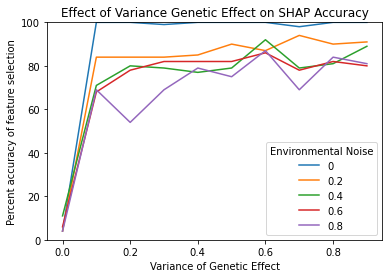

In [20]:
samples_n = 1000
loci_m = 20
range_values_g = 10
range_values_e = 5
number_trials = 50
b12_event = 0
#  g_vals,shap_values_SNP,e_vals = plot_shap_values_RFR_line_multiple(samples_n, loci_m, range_values_g, range_values_e, number_trials, 'RFR_set_1000', data_type = 'set')
# g_vals,shap_values_SNP,e_vals = plot_shap_values_RFR_line_multiple(samples_n, loci_m, range_values_g, range_values_e, number_trials,b12_event,'NN_twoloci_b12_0_set', data_type = 'set' )
g_vals,shap_values_SNP,e_vals = plot_shap_values_RFR_line_multiple(samples_n, loci_m, range_values_g, range_values_e, number_trials,b12_event,'RFR_two_loci_b12_0_var', data_type = 'var' )

In [ ]:
NN_two_lociList = []
NN_two_lociList.append(g_vals)
NN_two_lociList.append(shap_values_SNP)
NN_two_lociList.append(e_vals)


In [ ]:
#DUMPING
with open('/Users/kevin/Downloads/NN_two_lociList_var_b12_0', 'wb') as fp:
    pickle.dump(NN_two_lociList, fp)

In [ ]:
with open ('/Users/kevin/Downloads/NN_two_lociList_var_b12_0', 'rb') as fp:
    b12_0_Interaction = pickle.load(fp)

In [ ]:
g_vals= b12_0_Interaction[0]
shap_values_SNP= b12_0_Interaction[1]
e_vals = b12_0_Interaction[2]

In [ ]:
for x in range(0, len(shap_values_SNP)):
#     e_vals[x] = str(round(e_vals[x], 2))
    plt.plot(g_vals, shap_values_SNP[x], label = e_vals[x]) 
    

plt.xlabel('Variance of Genetic Effect')
plt.ylabel('Percent accuracy of feature selection')
plt.ylim([0,100])
plt.title('Effect of Variance Genetic Effect on SHAP Accuracy')     
plt.legend(title = 'Environmental Noise')
plt.savefig('RFR_twoloci_var_b12_5')